## Import dependencies

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import klib

from sklearn.metrics import mean_absolute_error  # MAE => Mean absolute error regression loss
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest

## Load data

In [34]:
df = pd.read_excel("../data/raw/entrenamiento.xlsx")
df = df.rename(columns={"C7.1": "C8", "des": "QUALITY"})
features = df.drop(columns=["QUALITY"])
target = df["QUALITY"]

## Dataframe that contains rows without NaN values
### Drop missing values


In [36]:
# Dataframe without missing values
df_without_nan = df.dropna()
features_without_nan = df_without_nan.drop(columns=["QUALITY"])

In [37]:
features_without_nan

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11
0,6.8,0.190620,0.307485,18.1,46.00,32.0,4.897840,1.00000,3.27,0.392042,8.8
2,6.7,0.350657,0.329304,12.1,0.04,61.0,5.517453,0.99794,3.31,0.457425,9.7
3,6.8,0.254642,0.405465,13.3,53.00,48.0,5.273000,0.99740,3.09,0.371564,9.4
4,6.6,0.215111,0.239017,15.8,35.00,46.0,5.241747,0.99820,3.24,0.412110,9.2
5,6.7,0.329304,0.215111,2.7,17.00,22.0,4.394449,0.99084,3.03,0.314811,11.5
...,...,...,...,...,...,...,...,...,...,...,...
3909,6.6,4.454347,0.285179,1.4,36.00,17.0,4.700480,0.99306,3.27,0.476234,9.5
3910,7.0,0.148420,0.223144,14.3,44.00,27.0,5.010635,998.00000,2.91,0.378436,9.2
3914,8.1,0.378436,0.270027,1.7,52.00,50.0,5.214936,0.99230,3.03,0.350657,11.2
3915,6.1,0.148420,0.254642,6.0,0.03,29.0,4.976734,0.99474,3.68,0.378436,10.7


In [38]:
features_without_nan.describe().T

,count,mean,std,min,25%,50%,75%,max
C1,1788.0,6.874469,0.834886,3.800000,6.300000,6.800000,7.300000,11.800000
C2,1788.0,0.422966,0.993684,0.076961,0.190620,0.239017,0.285179,6.809039
C3,1788.0,0.284209,0.086898,0.000000,0.239017,0.270027,0.329304,0.693147
C4,1788.0,6.467058,4.960735,0.600000,1.800000,5.500000,10.125000,31.600000
C5,1788.0,40.978238,25.637221,0.020000,33.000000,42.000000,49.000000,346.000000
C6,1788.0,35.129474,17.602331,2.000000,23.000000,33.000000,46.000000,289.000000
C7,1788.0,4.886258,0.356975,2.302585,4.689044,4.919981,5.141664,6.089045
C8,1788.0,57.653258,230.420785,0.987220,0.991800,0.994230,0.996785,999.000000
C9,1788.0,3.189279,0.153691,2.740000,3.087500,3.175000,3.280000,3.810000
C10,1788.0,0.395943,0.073354,0.198851,0.343590,0.385262,0.438255,0.698135


In [39]:
# Filter the DataFrame to keep only the rows where 'C8' is greater than 990
# Max value are a few in the dataframe. They need to be analyzed as possible outliers
data_c8_990 = df_without_nan[df_without_nan['C8'] >= 990]
data_c8_990

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,QUALITY
14,7.6,0.246860,0.329304,1.2,38.0,21.0,4.753590,994.0,3.16,0.512824,10.0,6
70,6.8,0.157004,0.157004,5.1,49.0,26.0,4.418841,993.0,3.00,0.322083,9.8,6
139,5.4,0.254642,0.385262,3.0,52.0,47.0,4.983607,993.0,3.29,0.559616,10.0,6
144,8.0,0.198851,0.270027,5.6,49.0,24.0,4.584967,993.0,3.10,0.350657,10.9,5
145,7.0,0.385262,0.067659,1.1,35.0,17.0,5.023881,991.0,3.02,0.292670,10.5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3709,7.3,0.182322,0.314811,1.2,37.0,48.0,4.787492,992.0,3.32,0.398776,10.9,6
3731,8.1,0.215111,0.322083,4.3,44.0,49.0,5.153292,996.0,3.37,0.553885,10.8,6
3780,5.7,0.165514,0.198851,4.2,42.0,25.0,4.718499,994.0,3.35,0.329304,9.4,5
3887,6.8,0.165514,0.314811,1.5,27.0,37.0,4.543295,992.0,3.30,0.371564,10.8,6


In [40]:
print(
    f"The value greater than 990 appears {data_c8_990.shape[0]} in the column C8. It's a {(data_c8_990.shape[0] / len(df_without_nan)) * 100:.2f}% of the data.")

The value greater than 990 appears 102 in the column C8. It's a 5.70% of the data.


## Visualize variable distributions

/tmp/ipykernel_20451/2159416769.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/2159416769.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/2159416769.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/2159416769.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/2159416769.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/2159416769.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/2159416769.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/2159416769.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/2159416769.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/

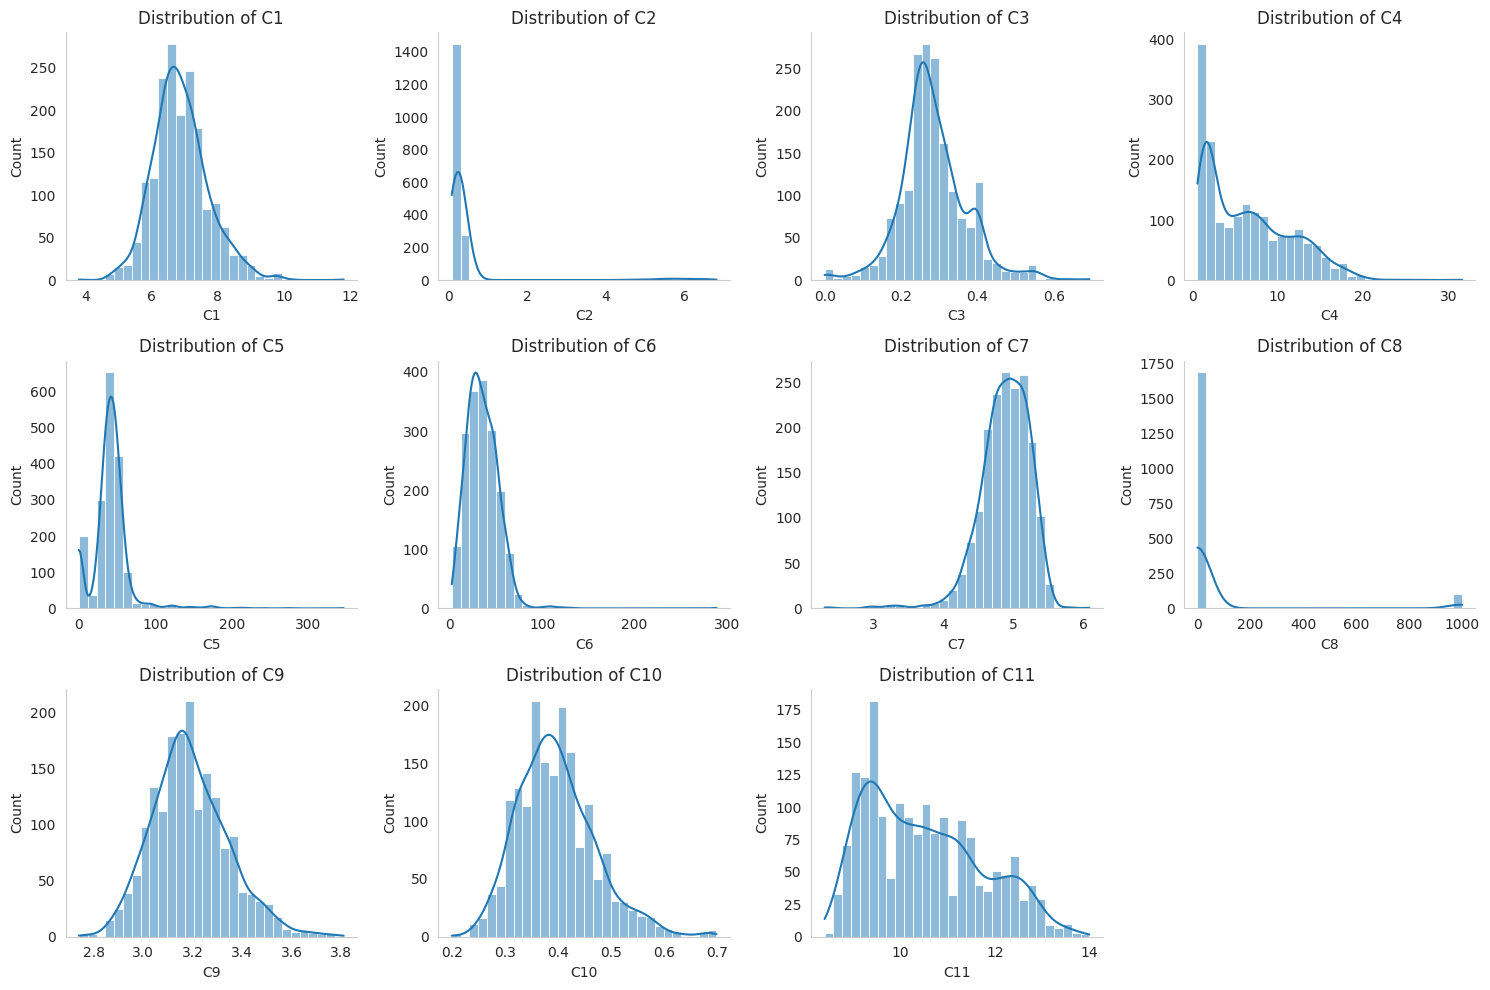

In [41]:
plt.figure(figsize=(15, 10))

# Plotting the distribution of each column
for i, column in enumerate(features_without_nan, 1):
    plt.subplot(3, 4, i)
    sns.histplot(features_without_nan[column], bins=30, kde=True)
    plt.title(f"Distribution of {column}")
    plt.tight_layout()
    plt.grid(False)
    sns.despine()
plt.show()

/home/alberte/Desktop/Fruit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/alberte/Desktop/Fruit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/alberte/Desktop/Fruit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/alberte/Desktop/Fruit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/alberte/Desktop/Fruit/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/alberte/Desktop/Fruit/.venv/lib/python3.10/site-packages/seaborn/axis

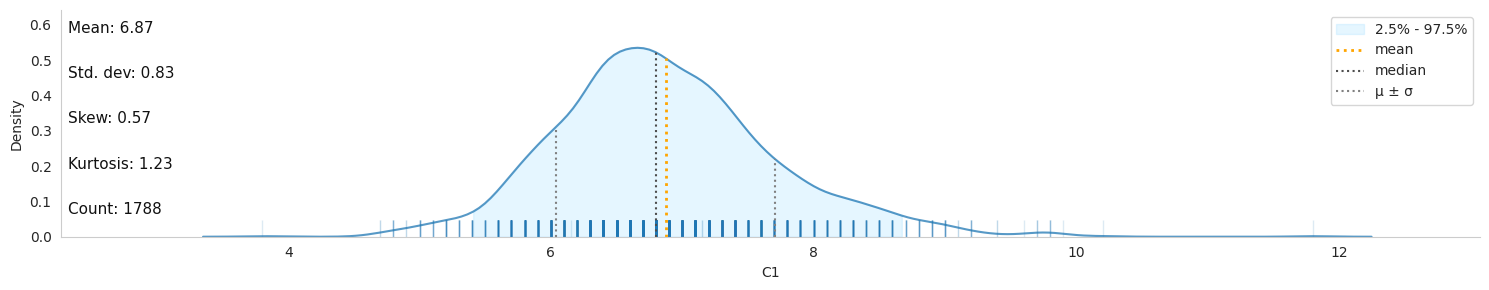

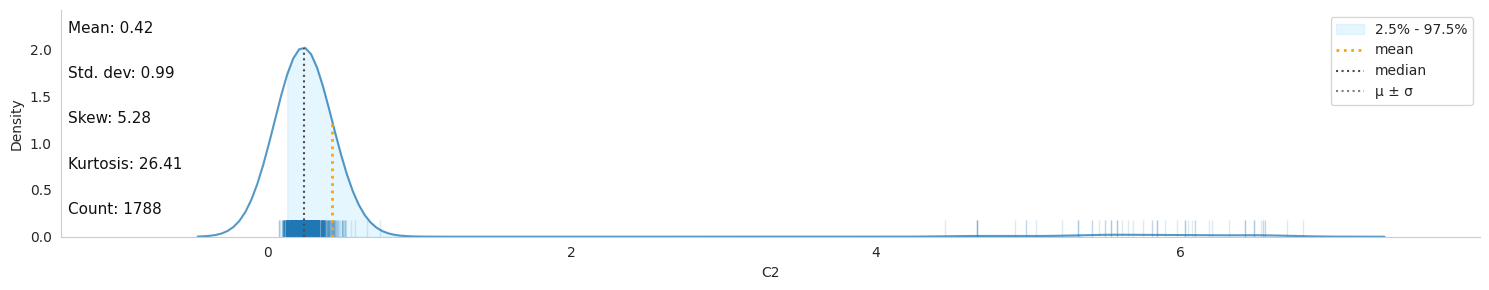

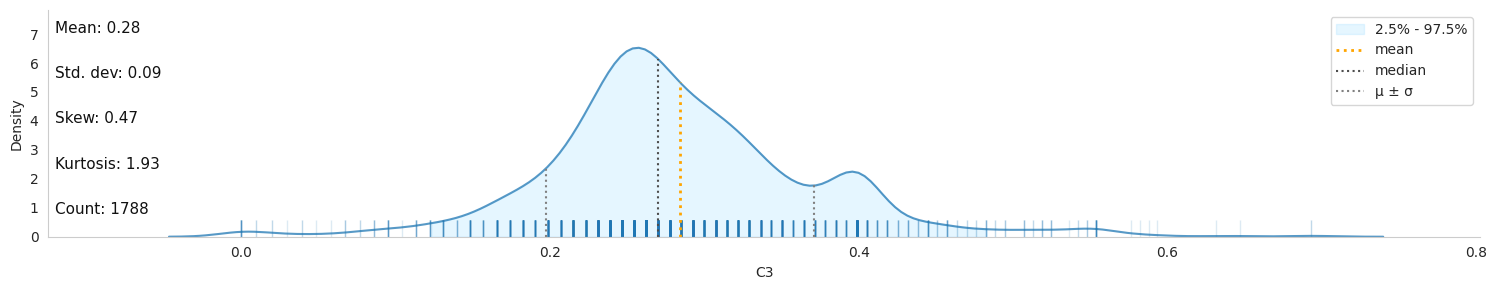

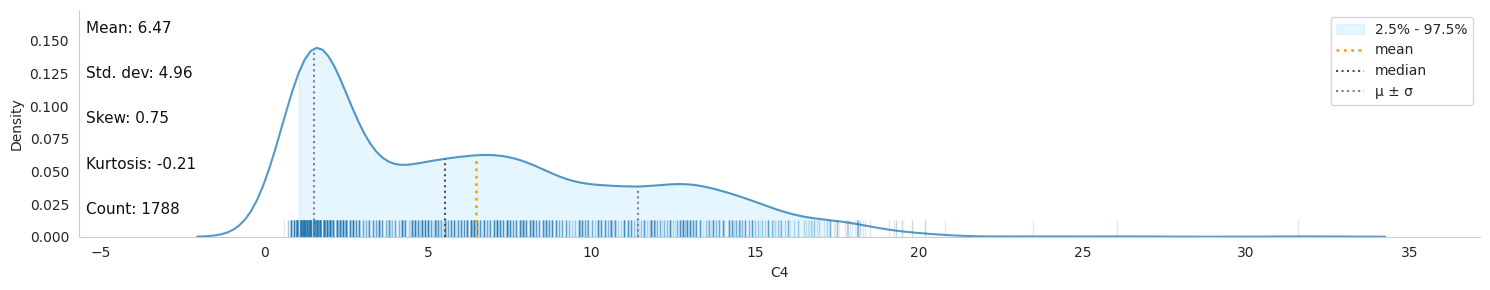

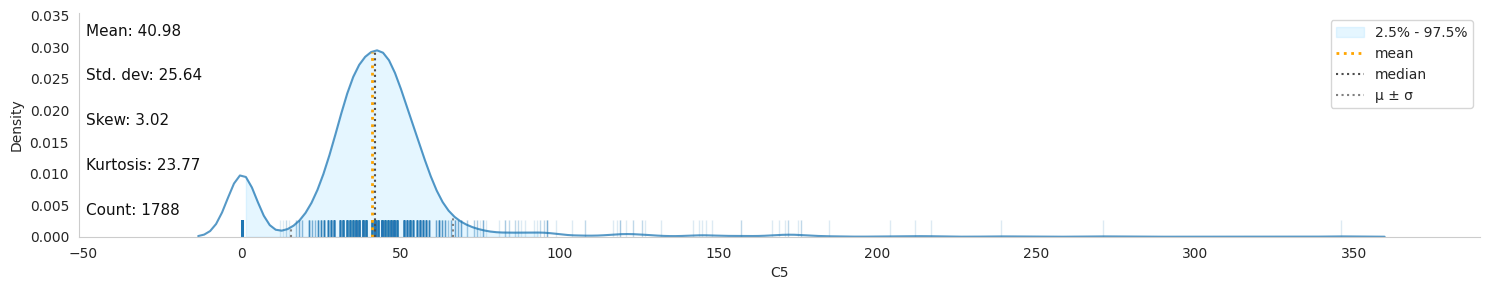

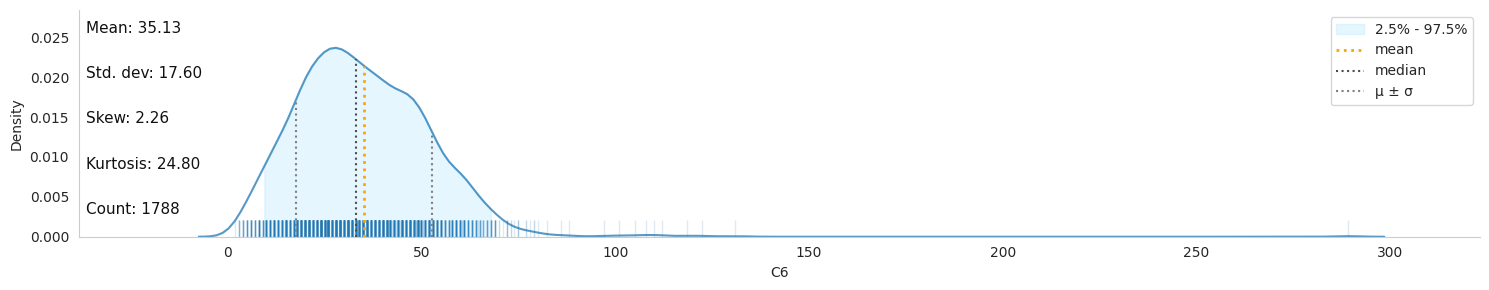

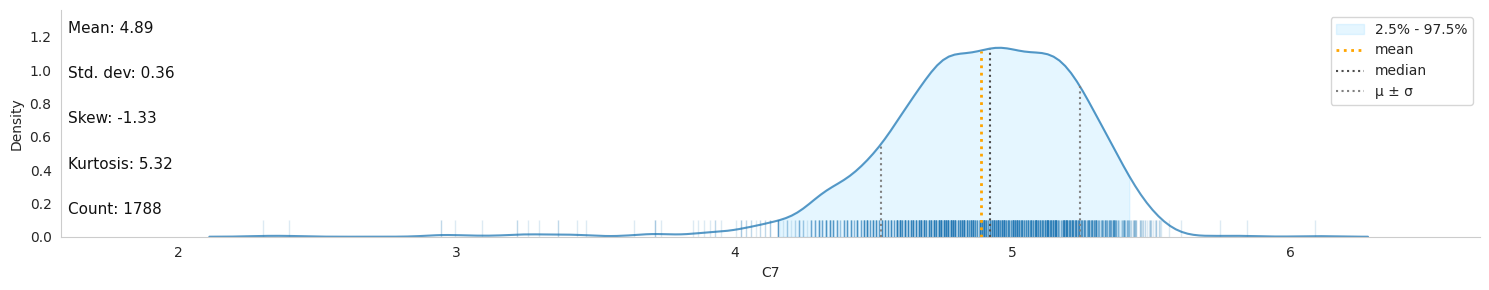

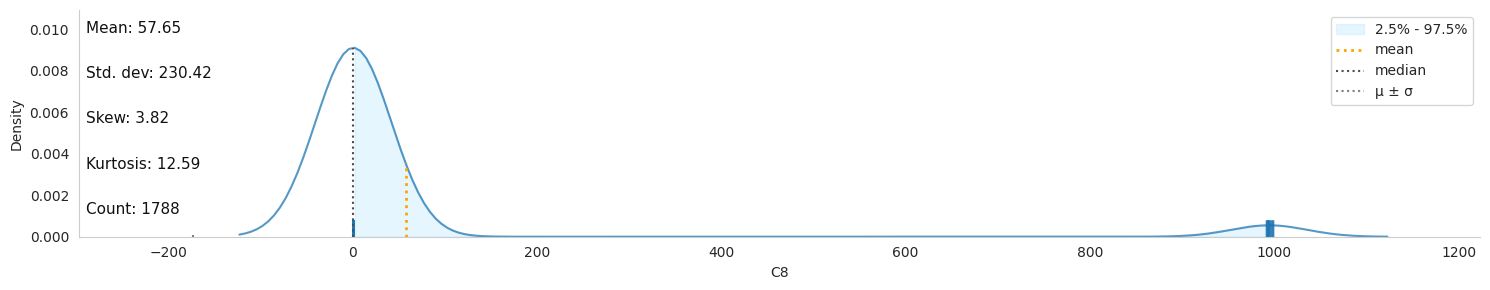

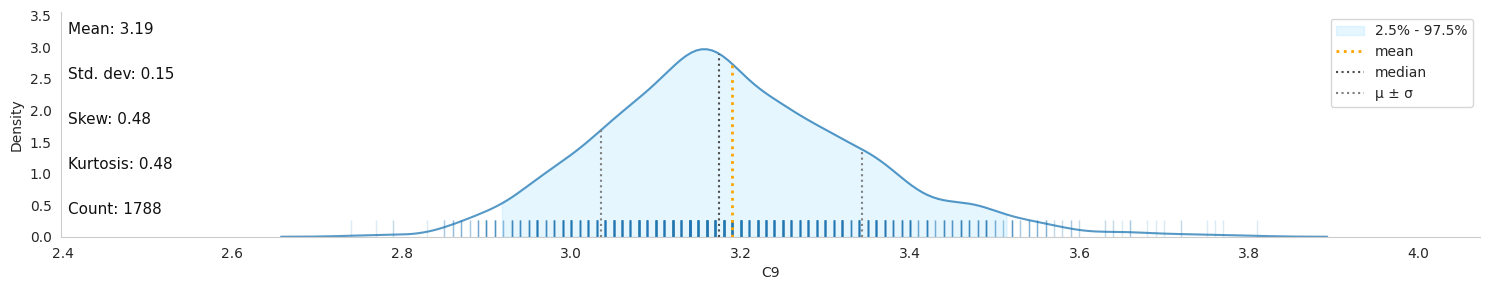

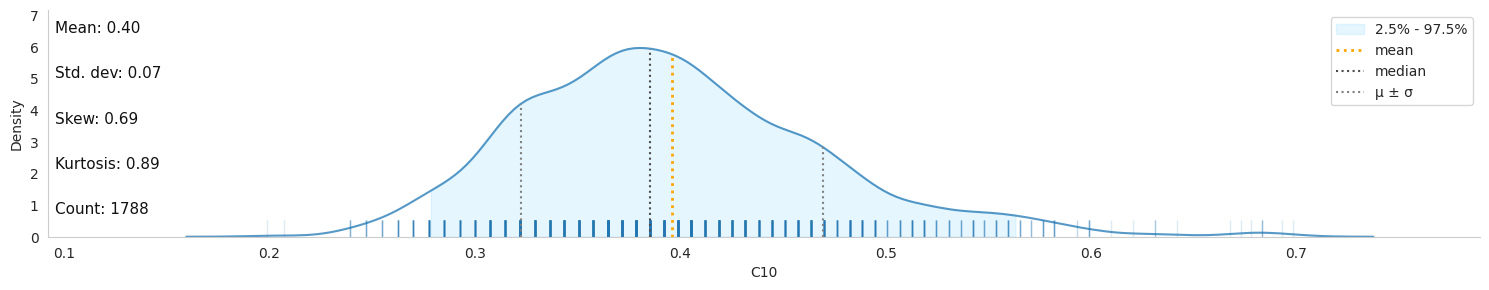

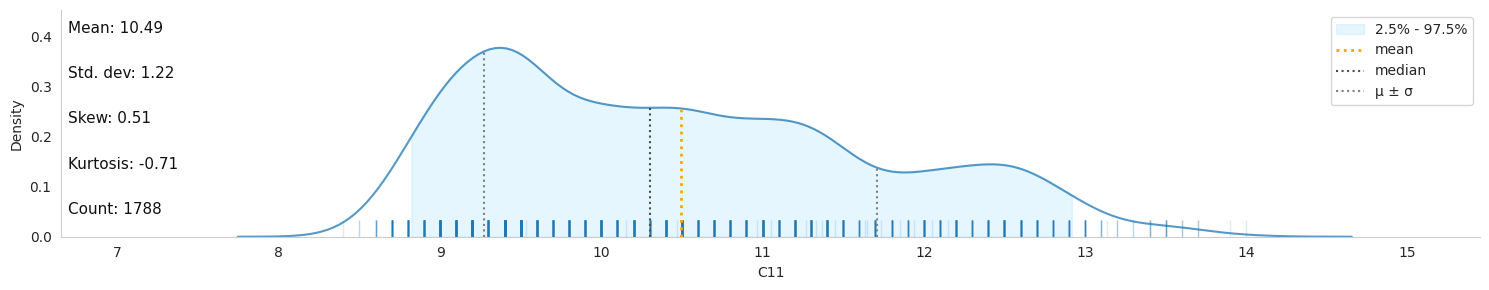

In [42]:
# Plotting all columns of features_without_nan
for i, column in enumerate(features_without_nan.columns, 1):
    klib.dist_plot(features_without_nan[column])
    plt.grid()

## Plot to see possible outliers

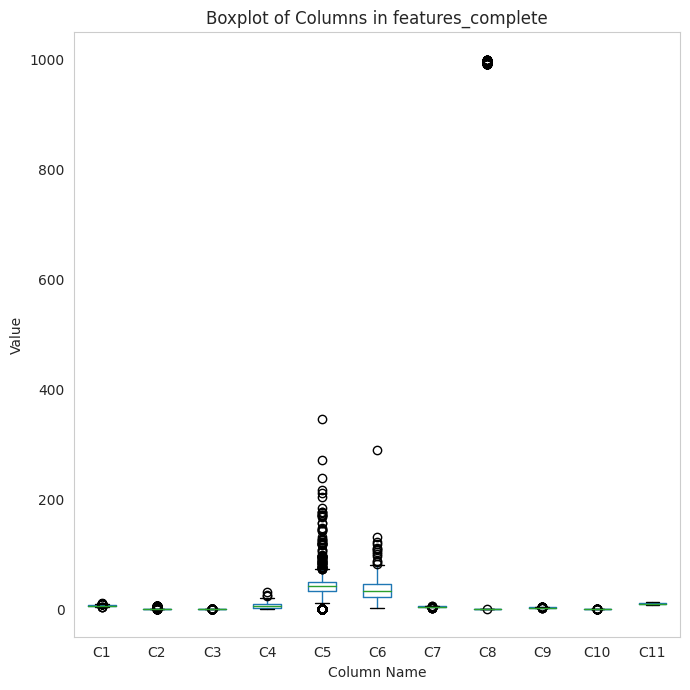

In [43]:
plt.figure(figsize=(7,7))
features_without_nan.boxplot()
plt.title('Boxplot of Columns in features_complete')
plt.ylabel('Value')
plt.xlabel('Column Name')
plt.grid(False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_20451/1621953684.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/1621953684.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/1621953684.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/1621953684.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/1621953684.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/1621953684.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/1621953684.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/1621953684.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_20451/1621953684.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/

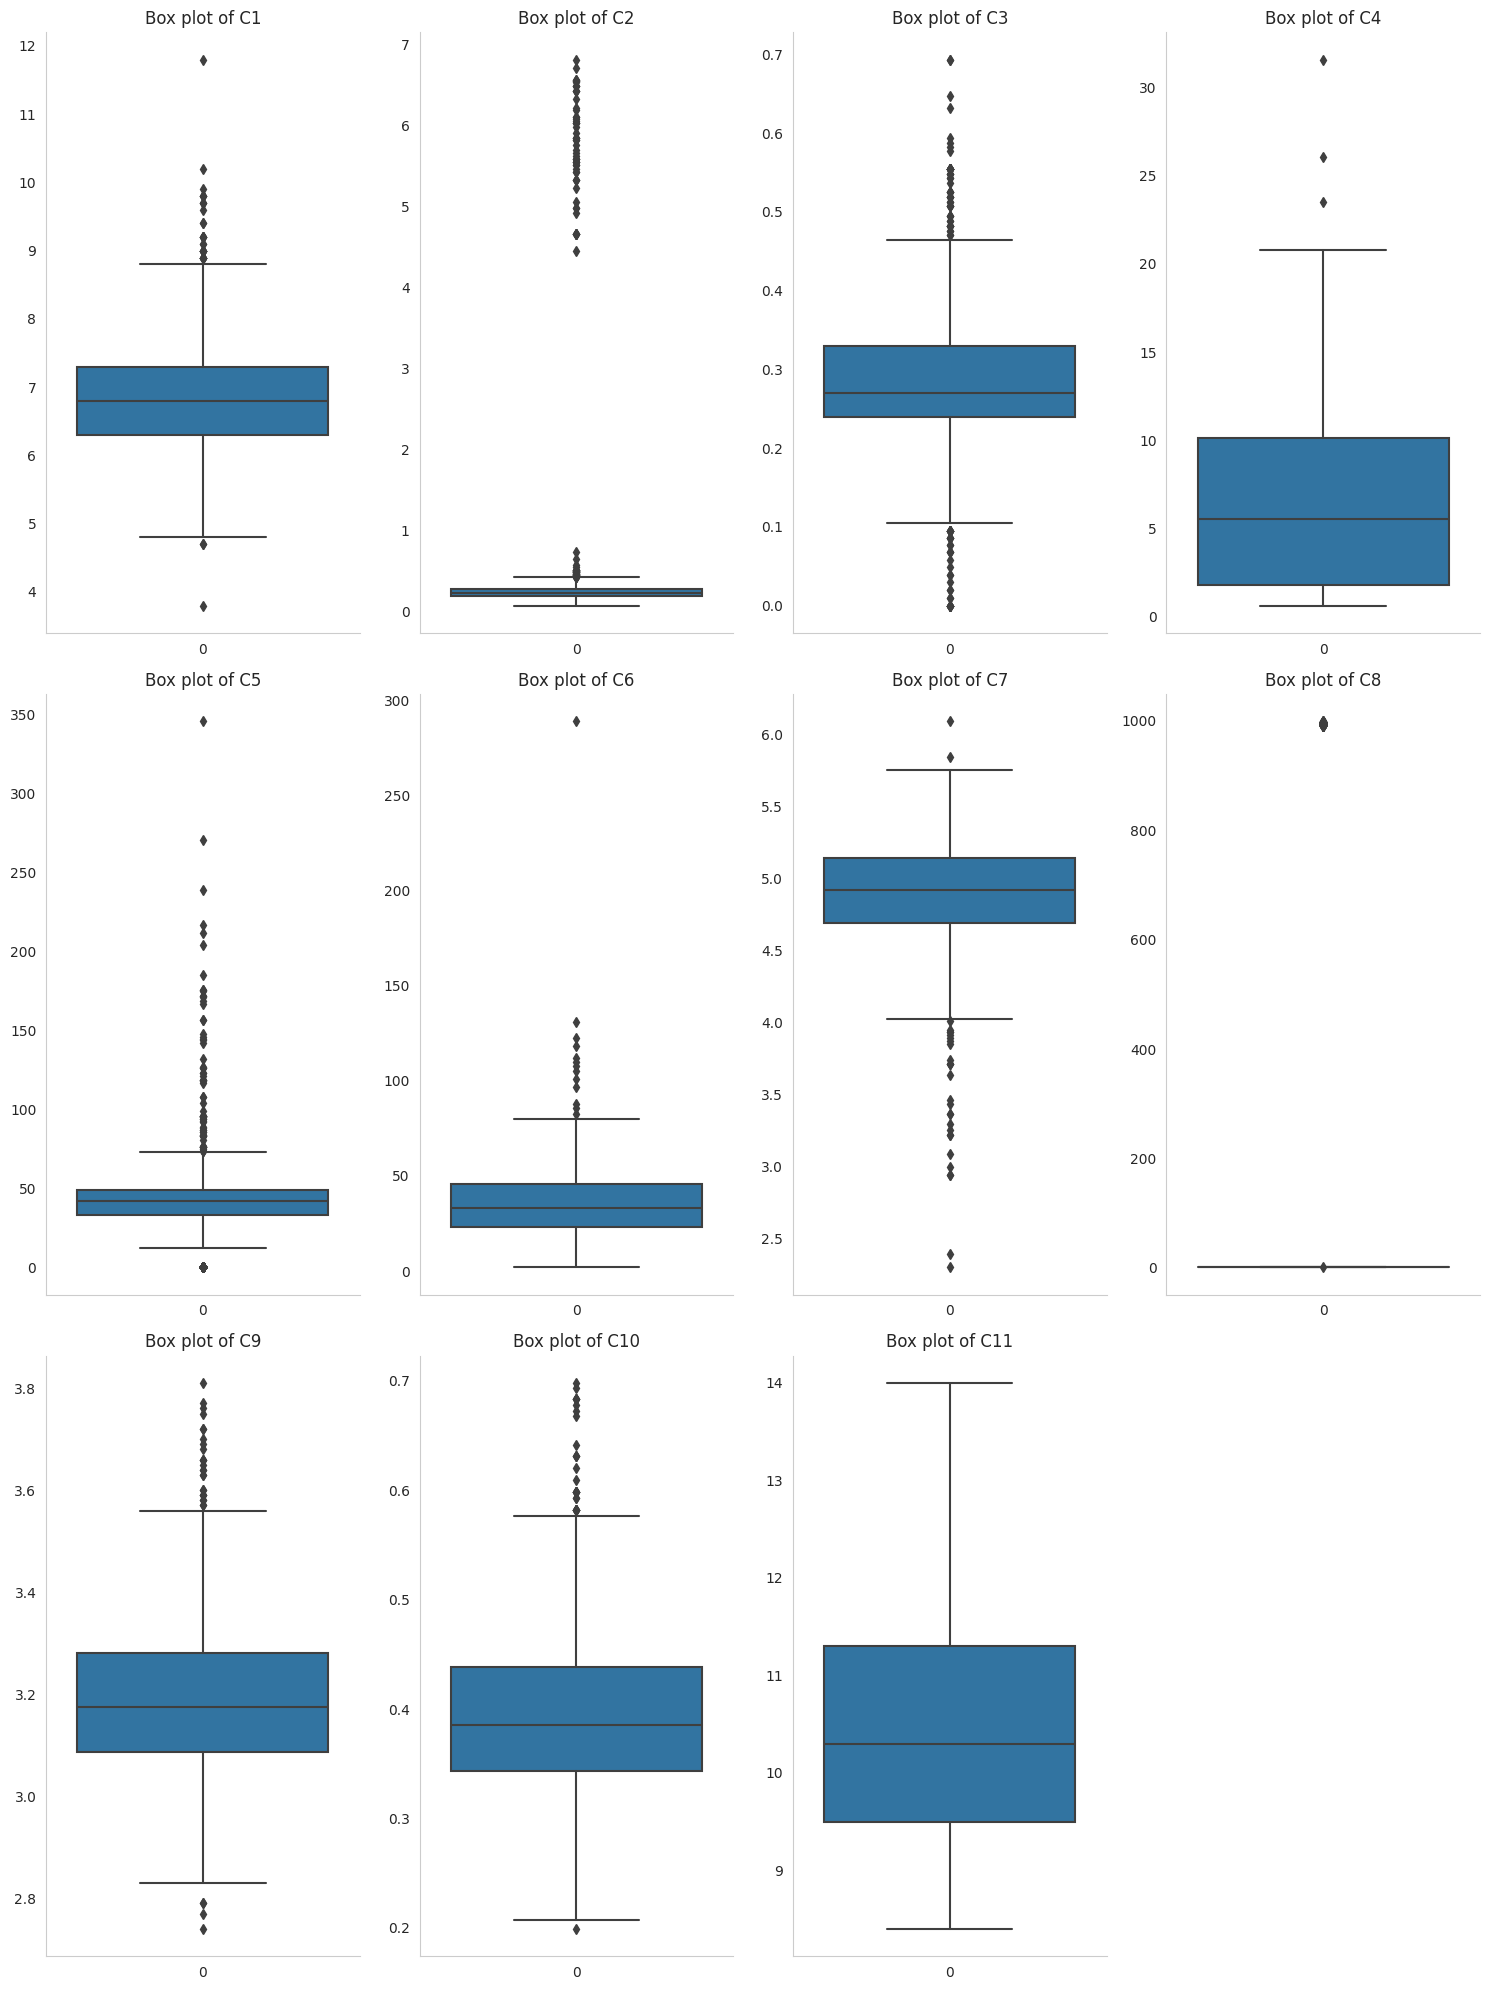

In [46]:
# Boxplot for all feature columns
plt.figure(figsize=(15, 20))

for i, column in enumerate(features_without_nan, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(features_without_nan[column])
    plt.title(f"Box plot of {column}")
    plt.tight_layout()
    plt.grid(False)
    sns.despine()
    
plt.show()

/tmp/ipykernel_20451/2171556374.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


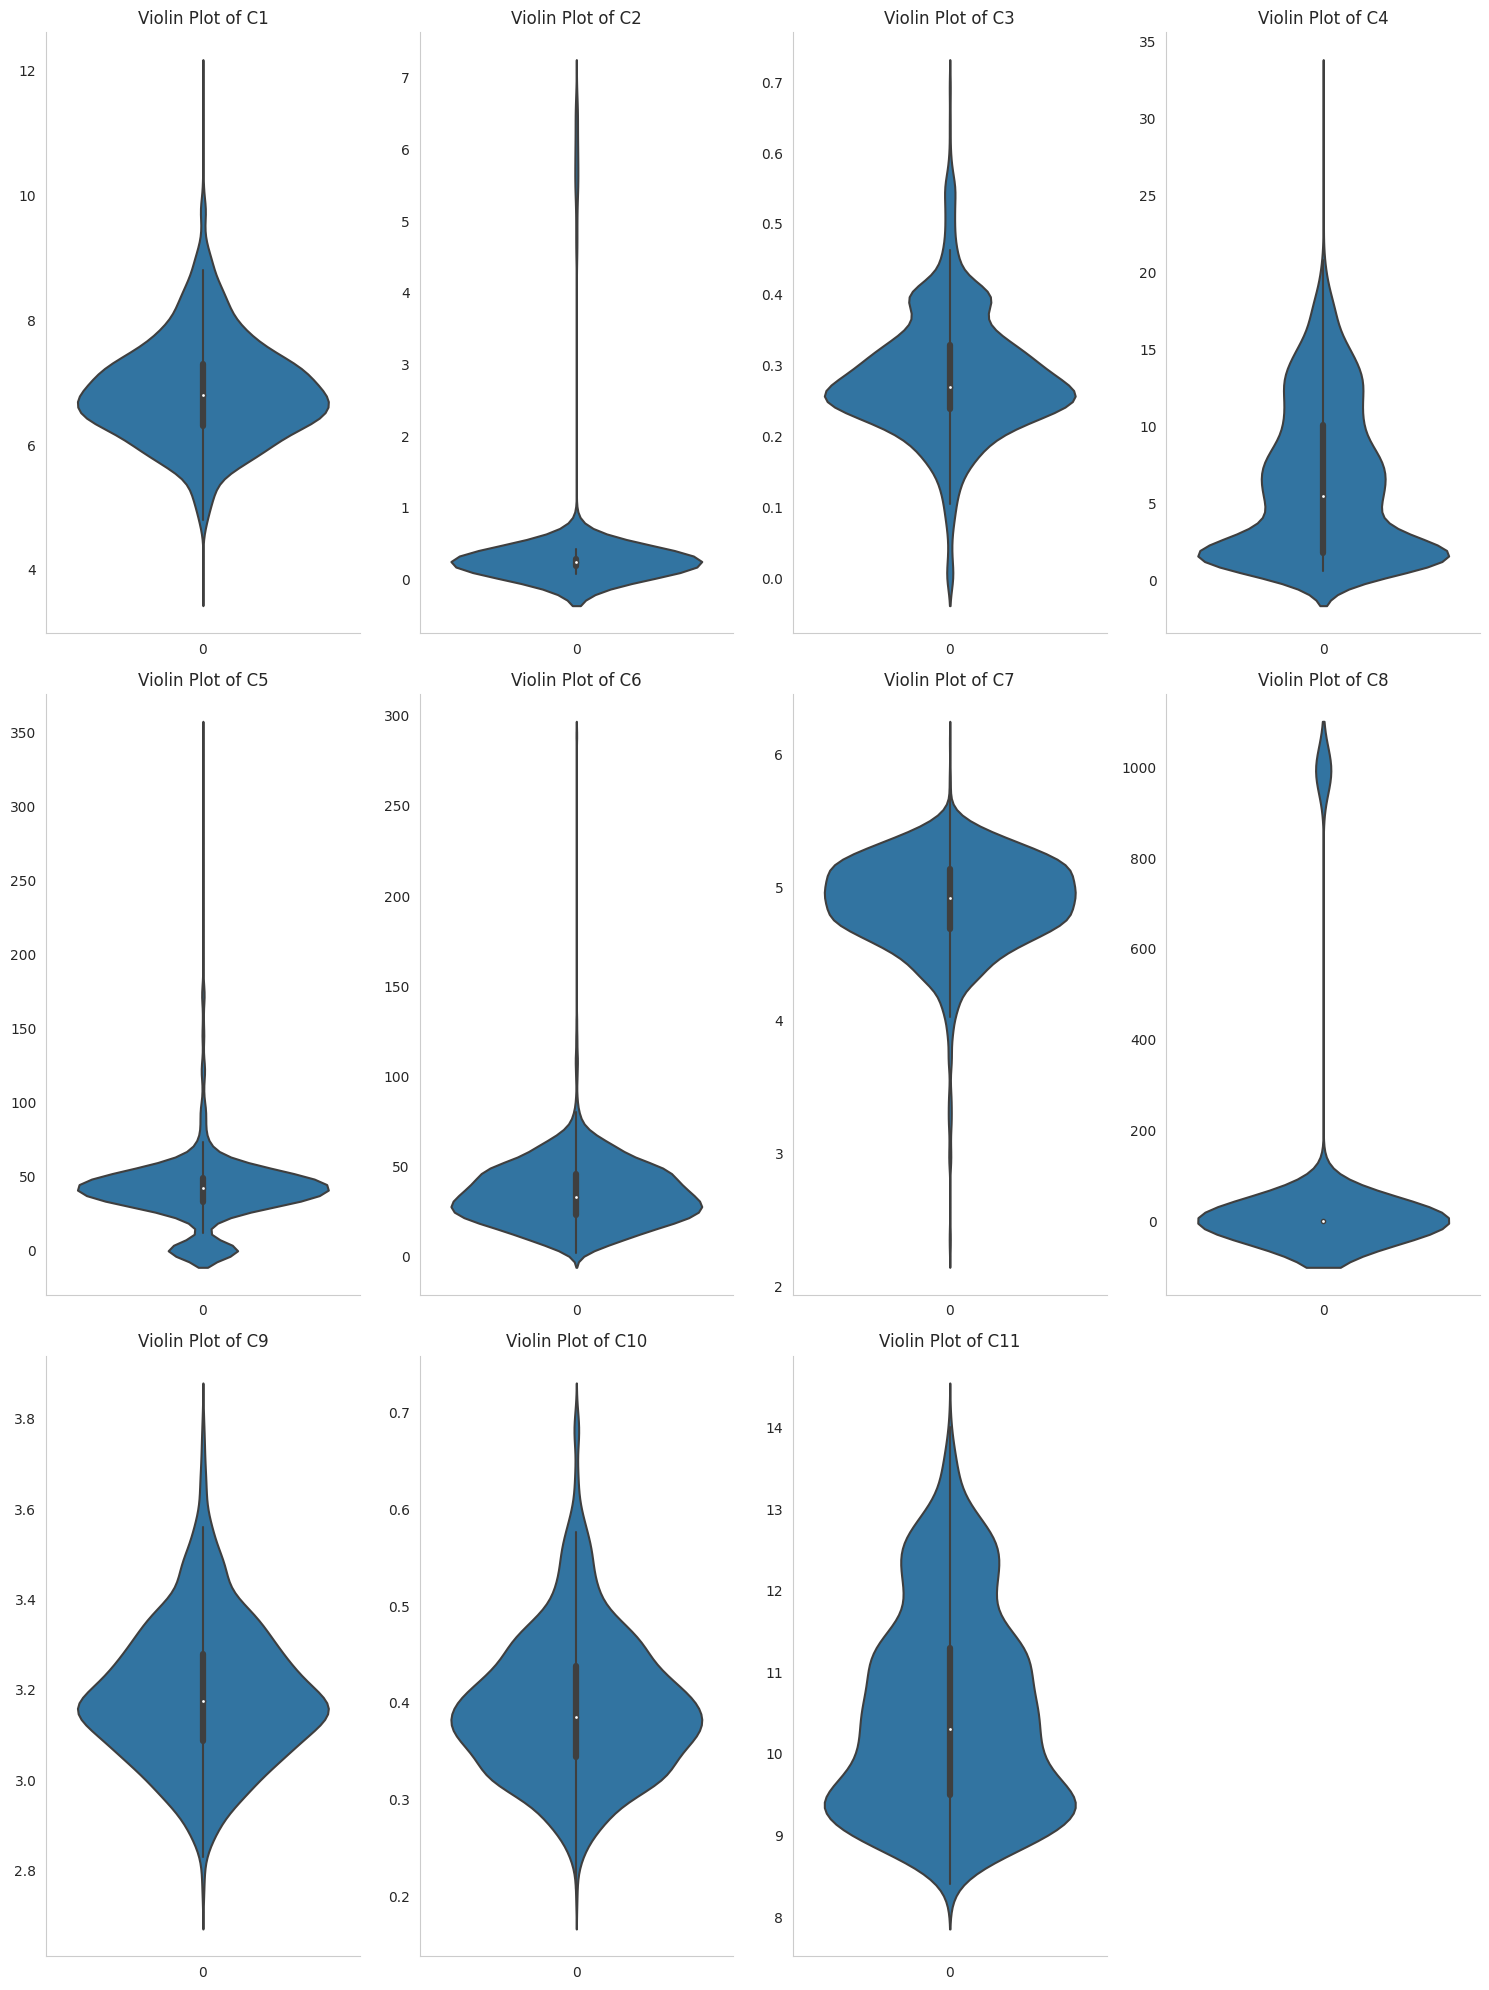

In [47]:
# Violin plot for all feature columns 
plt.figure(figsize=(15, 20))

for i, column in enumerate(features_without_nan, 1):
    plt.subplot(3, 4, i)
    sns.violinplot(features_without_nan[column])
    plt.title(f"Violin Plot of {column}")
    plt.tight_layout()
    plt.grid(False)
    sns.despine()
    
plt.show()

## Add random NaN to data_complete dataframe

In [49]:
# Copy of the features dataframe
features_fill_nan = features_without_nan.copy()

# Calculate the percentage of NaN values in each column of the original data
nan_percentages_original = df.isna().mean() * 100

# Apply custom percentages of NaN values to each column
np.random.seed(0)

for col in features_fill_nan:
    mask = np.random.rand(features_fill_nan.shape[0]) < (nan_percentages_original[col] / 100)
    features_fill_nan.loc[mask, col] = np.nan

features_fill_nan

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11
0,6.8,0.190620,0.307485,18.1,46.00,32.0,4.897840,1.00000,3.27,0.392042,8.8
2,6.7,0.350657,0.329304,12.1,0.04,61.0,5.517453,0.99794,3.31,0.457425,9.7
3,6.8,0.254642,0.405465,13.3,53.00,48.0,5.273000,0.99740,3.09,0.371564,9.4
4,6.6,0.215111,0.239017,15.8,35.00,46.0,5.241747,0.99820,3.24,0.412110,9.2
5,6.7,NaN,0.215111,2.7,17.00,NaN,4.394449,0.99084,3.03,0.314811,11.5
...,...,...,...,...,...,...,...,...,...,...,...
3909,6.6,4.454347,0.285179,1.4,36.00,17.0,4.700480,0.99306,3.27,0.476234,9.5
3910,7.0,0.148420,0.223144,14.3,44.00,27.0,NaN,998.00000,2.91,0.378436,9.2
3914,8.1,0.378436,0.270027,1.7,52.00,50.0,5.214936,0.99230,3.03,0.350657,11.2
3915,6.1,0.148420,0.254642,6.0,0.03,29.0,4.976734,0.99474,3.68,0.378436,10.7


## Use different methods to impute a value to missing values in features_complete_nan

### Imputation of missing values using MEAN

In [50]:
data_imputed_mean = features_fill_nan.fillna(features_fill_nan.mean())

data_imputed_mean

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11
0,6.8,0.190620,0.307485,18.1,46.00,32.0,4.897840,1.00000,3.27,0.392042,8.8
2,6.7,0.350657,0.329304,12.1,0.04,61.0,5.517453,0.99794,3.31,0.457425,9.7
3,6.8,0.254642,0.405465,13.3,53.00,48.0,5.273000,0.99740,3.09,0.371564,9.4
4,6.6,0.215111,0.239017,15.8,35.00,46.0,5.241747,0.99820,3.24,0.412110,9.2
5,6.7,0.424280,0.215111,2.7,17.00,35.0,4.394449,0.99084,3.03,0.314811,11.5
...,...,...,...,...,...,...,...,...,...,...,...
3909,6.6,4.454347,0.285179,1.4,36.00,17.0,4.700480,0.99306,3.27,0.476234,9.5
3910,7.0,0.148420,0.223144,14.3,44.00,27.0,4.887404,998.00000,2.91,0.378436,9.2
3914,8.1,0.378436,0.270027,1.7,52.00,50.0,5.214936,0.99230,3.03,0.350657,11.2
3915,6.1,0.148420,0.254642,6.0,0.03,29.0,4.976734,0.99474,3.68,0.378436,10.7


In [51]:
## MAE for Mean imputation
mae_mean = mean_absolute_error(features_without_nan, data_imputed_mean)
print(f"The MAE based on mean imputation is: {mae_mean.__round__(4)}")

The MAE based on mean imputation is: 0.9076


### Imputation of missing values using MEDIAN

In [52]:
data_imputed_median = features_fill_nan.fillna(features_fill_nan.median())

data_imputed_median

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11
0,6.8,0.190620,0.307485,18.1,46.00,32.0,4.897840,1.00000,3.27,0.392042,8.8
2,6.7,0.350657,0.329304,12.1,0.04,61.0,5.517453,0.99794,3.31,0.457425,9.7
3,6.8,0.254642,0.405465,13.3,53.00,48.0,5.273000,0.99740,3.09,0.371564,9.4
4,6.6,0.215111,0.239017,15.8,35.00,46.0,5.241747,0.99820,3.24,0.412110,9.2
5,6.7,0.239017,0.215111,2.7,17.00,33.0,4.394449,0.99084,3.03,0.314811,11.5
...,...,...,...,...,...,...,...,...,...,...,...
3909,6.6,4.454347,0.285179,1.4,36.00,17.0,4.700480,0.99306,3.27,0.476234,9.5
3910,7.0,0.148420,0.223144,14.3,44.00,27.0,4.919981,998.00000,2.91,0.378436,9.2
3914,8.1,0.378436,0.270027,1.7,52.00,50.0,5.214936,0.99230,3.03,0.350657,11.2
3915,6.1,0.148420,0.254642,6.0,0.03,29.0,4.976734,0.99474,3.68,0.378436,10.7


In [53]:
## MAE for Mean imputation
mae_median = mean_absolute_error(features_without_nan, data_imputed_median)
print(f"The MAE based on median imputation is: {mae_median.__round__(4)}")

The MAE based on median imputation is: 0.5299


### Imputation of missing values using multivariate feature imputation

In [54]:
multivariate_imputer = IterativeImputer(max_iter=10, random_state=0)
data_imputed_multivariate = multivariate_imputer.fit_transform(features_fill_nan)
data_imputed_multivariate

array([[ 6.8       ,  0.19062036,  0.3074847 , ...,  3.27      ,
         0.39204209,  8.8       ],
       [ 6.7       ,  0.35065687,  0.32930375, ...,  3.31      ,
         0.45742485,  9.7       ],
       [ 6.8       ,  0.25464222,  0.40546511, ...,  3.09      ,
         0.37156356,  9.4       ],
       ...,
       [ 8.1       ,  0.37843644,  0.27002714, ...,  3.03      ,
         0.35065687, 11.2       ],
       [ 6.1       ,  0.14842001,  0.25464222, ...,  3.68      ,
         0.37843644, 10.7       ],
       [ 6.8       ,  0.16551444,  0.24686008, ...,  3.11      ,
         0.37156356, 10.9       ]])

In [55]:
mae_multivariate = mean_absolute_error(features_without_nan, data_imputed_multivariate)
print(f"The MAE based on multivariate imputation is: {mae_multivariate.__round__(4)}")

The MAE based on multivariate imputation is: 0.8737


### Imputation of missing values using KNN => Nearest Neighbors


In [58]:
knn_imputer = KNNImputer(n_neighbors=1)
data_imputed_knn = knn_imputer.fit_transform(features_fill_nan)
data_imputed_knn

array([[ 6.8       ,  0.19062036,  0.3074847 , ...,  3.27      ,
         0.39204209,  8.8       ],
       [ 6.7       ,  0.35065687,  0.32930375, ...,  3.31      ,
         0.45742485,  9.7       ],
       [ 6.8       ,  0.25464222,  0.40546511, ...,  3.09      ,
         0.37156356,  9.4       ],
       ...,
       [ 8.1       ,  0.37843644,  0.27002714, ...,  3.03      ,
         0.35065687, 11.2       ],
       [ 6.1       ,  0.14842001,  0.25464222, ...,  3.68      ,
         0.37843644, 10.7       ],
       [ 6.8       ,  0.16551444,  0.24686008, ...,  3.11      ,
         0.37156356, 10.9       ]])

In [59]:
mae_knn = mean_absolute_error(features_without_nan, data_imputed_knn)
print(f"The MAE based on KNN imputation is: {mae_knn.__round__(4)}")

The MAE based on KNN imputation is: 0.6439


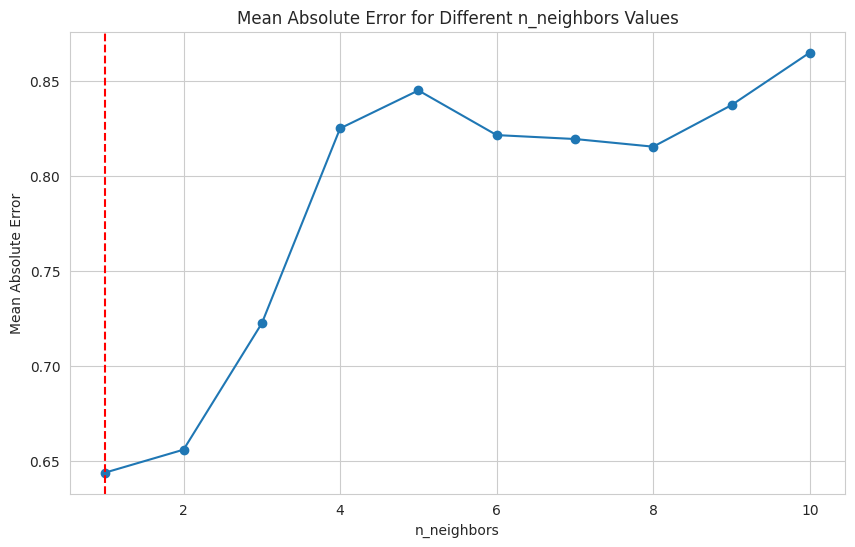

Best n_neighbors value is: 1


In [60]:
# Find best value for n_neighbors
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error

# Define a range of n_neighbors values to try
n_neighbors_values = range(1, 11)

# Initialize a list to store the MAE for each value of n_neighbors
mae_values = []

# For each value of n_neighbors...
for n_neighbors in n_neighbors_values:
    # Create a KNNImputer
    imputer_knn = KNNImputer(n_neighbors=n_neighbors)

    # Perform imputation
    data_imputed_knn = imputer_knn.fit_transform(features_fill_nan)

    # Convert back to DataFrame
    data_imputed_knn = pd.DataFrame(data_imputed_knn, columns=features_fill_nan.columns,
                                    index=features_fill_nan.index)

    # Calculate MAE
    mae = mean_absolute_error(features_without_nan, data_imputed_knn)

    # Store the MAE
    mae_values.append(mae)

# Create a DataFrame with the results
results = pd.DataFrame({
    'n_neighbors': n_neighbors_values,
    'MAE': mae_values
})

# Find the n_neighbors value with the smallest MAE
best_n_neighbors = results.loc[results['MAE'].idxmin(), 'n_neighbors']

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results['n_neighbors'], results['MAE'], marker='o')
plt.title('Mean Absolute Error for Different n_neighbors Values')
plt.xlabel('n_neighbors')
plt.ylabel('Mean Absolute Error')
plt.axvline(best_n_neighbors, color='red', linestyle='--')  # add a vertical line at the best n_neighbors value
plt.show()

print(f"Best n_neighbors value is: {best_n_neighbors}")

## Plot the different MAE values by imputation methods

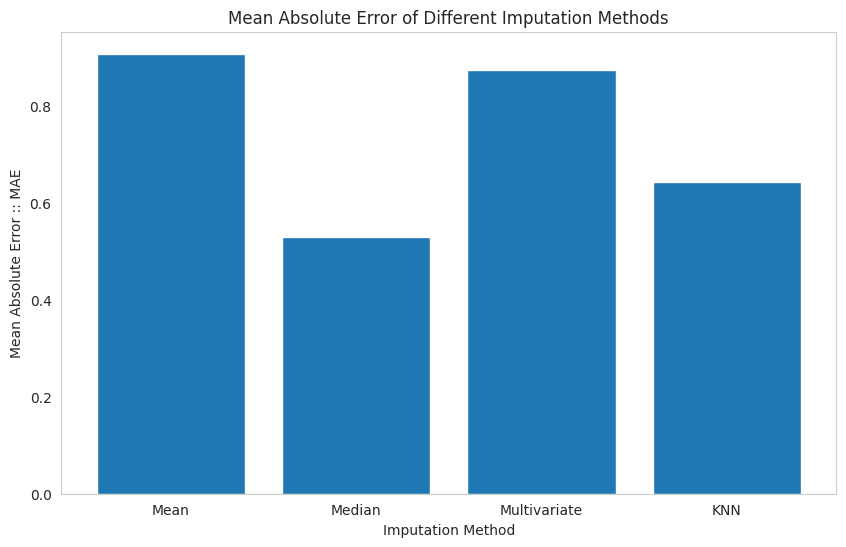

The MAE based on Mean imputation is: 0.9076
The MAE based on Median imputation is: 0.5299
The MAE based on Multivariate imputation is: 0.8737
The MAE based on KNN imputation is: 0.6439


In [66]:
# Create a DataFrame with the MAEs
mae_df = pd.DataFrame({'Imputation Method': ['Mean', 'Median', 'Multivariate', 'KNN'],
                       'MAE': [mae_mean, mae_median, mae_multivariate, mae_knn]})

# Plot
plt.figure(figsize=(10, 6))
plt.bar(mae_df['Imputation Method'], mae_df['MAE'])
plt.title('Mean Absolute Error of Different Imputation Methods')
plt.xlabel('Imputation Method')
plt.ylabel('Mean Absolute Error :: MAE')
plt.grid()
plt.show()

print(f"The MAE based on Mean imputation is: {mae_mean.__round__(4)}")
print(f"The MAE based on Median imputation is: {mae_median.__round__(4)}")
print(f"The MAE based on Multivariate imputation is: {mae_multivariate.__round__(4)}")
print(f"The MAE based on KNN imputation is: {mae_knn.__round__(4)}")